We first upload the files to google drive and then we mount the google drive.

In [1]:
#Mounting the files uploaded on google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


We import some important packages

In [2]:
#Importing the useful packages
import random
import numpy as np
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

from skimage.io import imread
from skimage.transform import resize


In [3]:
pip install scikit-image

In [4]:
import os
os.chdir("/content/drive/My Drive/inmas")

In [5]:
!pip3 install torch torchvision

We use the os commands to read the files from google drive

In [6]:
files = os.listdir()

In [7]:
#The folder contains some other files so we manualy remove them below
patient_ids = files[2:-1]

In [8]:
len(patient_ids) #number of patients

248

We count the number of labels which have cancer and which do not.

In [9]:
class_0_total = 0
class_1_total = 0
from pprint import pprint
for patient_id in patient_ids:
    class_0_files = os.listdir(patient_id + '/0')
    class_1_files = os.listdir(patient_id + '/1')

    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 
    

total_images = class_0_total + class_1_total
    
print(f'Number of patches in Class 0: {class_0_total}')
print(f'Number of patches in Class 1: {class_1_total}')
print(f'Total number of patches: {total_images}')

Number of patches in Class 0: 164947
Number of patches in Class 1: 68252
Total number of patches: 233199


We will create a dataframe with the columns patient_id, x coordinate of patch, y coordinate of patch, target label and the path of the image

In [10]:
columns = ["patient_id",'x','y',"target","path"]
data_rows = []
i = 0
iss = 0
isss = 0

# note that we loop through the classes after looping through the 
# patient ids so that we avoid splitting our data into [all class 0 then all class 1]
for patient_id in patient_ids:
    for c in [0,1]:
        class_path = patient_id + '/' + str(c) + '/'
        imgs = os.listdir(class_path)
        
        # Extracting Image Paths
        img_paths = [class_path + img + '/' for img in imgs]
        
        # Extracting Image Coordinates
        img_coords = [img.split('_',4)[2:4] for img in imgs]
        x_coords = [int(coords[0][1:]) for coords in img_coords]
        y_coords = [int(coords[1][1:]) for coords in img_coords]

        for (path,x,y) in zip(img_paths,x_coords,y_coords):
            values = [patient_id,x,y,c,path]
            data_rows.append({k:v for (k,v) in zip(columns,values)})
# We create a new dataframe using the list of dicts that we generated above
cancer_data = pd.DataFrame(data_rows)

We print out a few rows of the data frame to check how the entries look.

In [11]:
print(f'Shape of Dataframe: {cancer_data.shape}')
cancer_data[0:525]

Shape of Dataframe: (233199, 5)


,patient_id,x,y,target,path
0,10253,1001,1001,0,10253/0/10253_idx5_x1001_y1001_class0.png/
1,10253,1101,1201,0,10253/0/10253_idx5_x1101_y1201_class0.png/
2,10253,1101,551,0,10253/0/10253_idx5_x1101_y551_class0.png/
3,10253,1101,1001,0,10253/0/10253_idx5_x1101_y1001_class0.png/
4,10253,1001,601,0,10253/0/10253_idx5_x1001_y601_class0.png/
...,...,...,...,...,...
520,10253,851,501,1,10253/1/10253_idx5_x851_y501_class1.png/
521,10253,701,501,1,10253/1/10253_idx5_x701_y501_class1.png/
522,10253,701,351,1,10253/1/10253_idx5_x701_y351_class1.png/
523,10253,801,651,1,10253/1/10253_idx5_x801_y651_class1.png/


# Visualizing Data
Here we plot histograms for number of patches per patient and percentage of patches with cancer.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '% of patches with IDC')

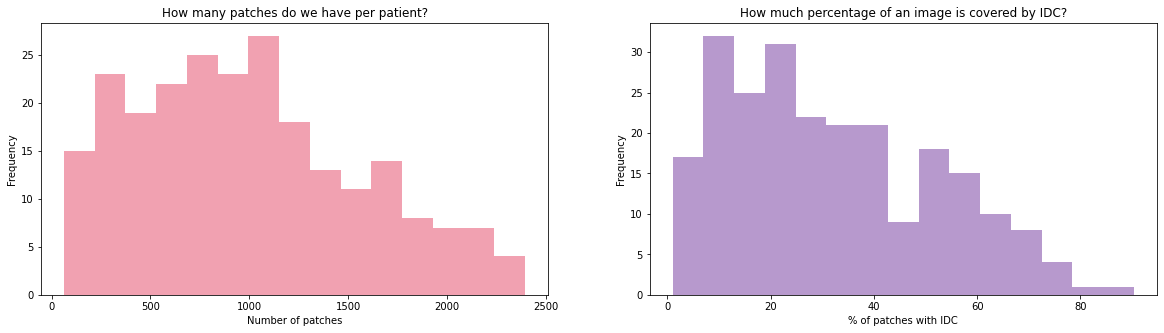

In [12]:
cancer_perc = cancer_data.groupby("patient_id").target.value_counts()/ cancer_data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,2,figsize=(20,5))

# Plotting Frequency of Patches per Patient
sns.distplot(cancer_data.groupby("patient_id").size(), ax=ax[0], color="crimson", kde=False, bins=15)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plotting Percentage of an image that is covered by Invasive Ductile Carcinoma
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="indigo", kde=False, bins=15)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")




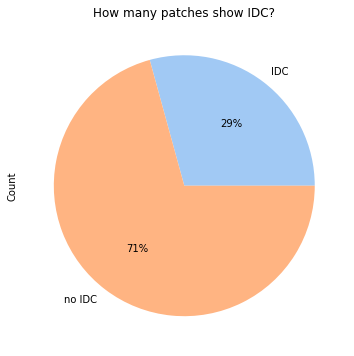

In [13]:
# Plotting number of patches that show IDC
fig, ax = plt.subplots(1,1,figsize=(6,6))
pnum=len(cancer_data[cancer_data.target==1])
nnum=len(cancer_data[cancer_data.target==0])
piedata = [float(pnum), float(nnum)]
labels = ['IDC', 'no IDC']
colors = sns.color_palette('pastel')
plt.pie(piedata, labels=labels ,colors = colors,autopct = '%0.0f%%')
plt.ylabel("Count")
plt.title("How many patches show IDC?");
plt.show()

We create a heat map to show where most cancerous cells are usually found.

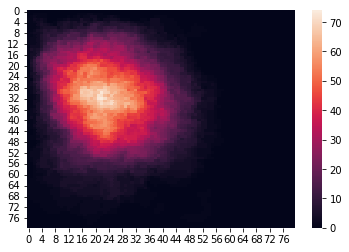

In [14]:
heat = np.zeros((80,80))

for index, row in cancer_data[cancer_data.target==1].iterrows():
  x = int((row['x']-1)/50)
  y = int((row['y']-1)/50)
  heat[x,y] += 1

ax2 =sns.heatmap(heat)

# Refining the data
The data above had severe bias because most of the samples did not contain cancer. So we have to balnce this out before feeding it into a machine learning algorithm.

To balance, we use the heat map to figure out where the cancer is usually found and re sample from that region.

After refining we visualize the data again to see if there is any improvement.

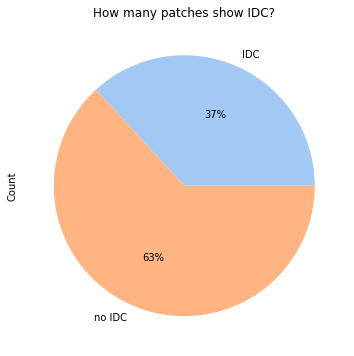

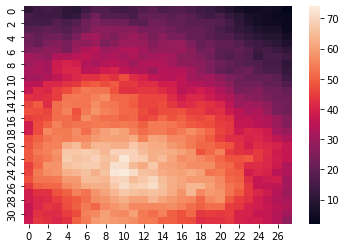

In [15]:
#Refining data manually because there is no enough ram for PCA
cancer_data_subset= cancer_data.loc[(cancer_data.x>400) & (cancer_data.x<2000) & (cancer_data.y>600) & (cancer_data.y<2000)]



# Plotting number of patches that show IDC after refinement
fig, ax = plt.subplots(1,1,figsize=(6,6))
pnum=len(cancer_data_subset[cancer_data_subset.target==1])
nnum=len(cancer_data_subset[cancer_data_subset.target==0])
piedata = [float(pnum), float(nnum)]
labels = ['IDC', 'no IDC']
colors = sns.color_palette('pastel')
plt.pie(piedata, labels=labels ,colors = colors,autopct = '%0.0f%%')
plt.ylabel("Count")
plt.title("How many patches show IDC?");
plt.show()

#heat map zoomed in
heat_ref = np.zeros((32,28))




for index, row in cancer_data_subset[cancer_data_subset.target==1].iterrows():

  x = int((row['x']-1)/50)-8

  y = int((row['y']-1)/50)-12

  heat_ref[x,y] += 1




ax2 =sns.heatmap(heat_ref)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 35.0)

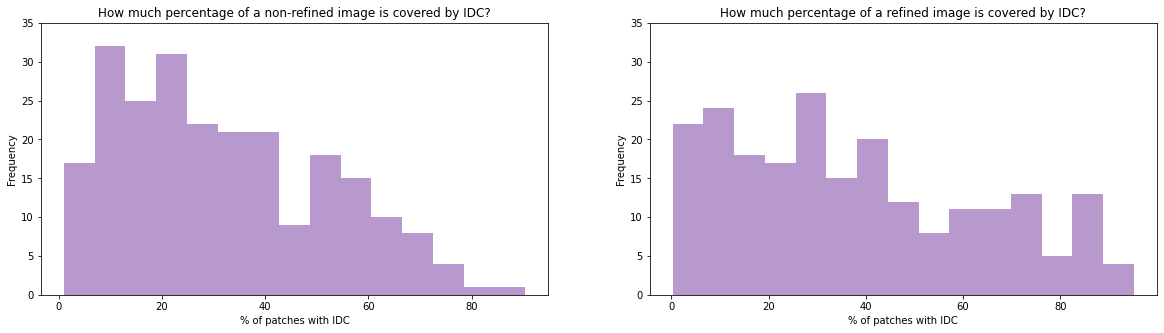

In [16]:
#refined data chart
newcancer_perc = cancer_data_subset.groupby("patient_id").target.value_counts()/ cancer_data_subset.groupby("patient_id").target.size()
newcancer_perc = newcancer_perc.unstack()

fig, ax = plt.subplots(1,2,figsize=(20,5))
# Plotting Percentage of a non-refined image that is covered by Invasive Ductile Carcinoma
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[0], color="indigo", kde=False, bins=15)
ax[0].set_title("How much percentage of a non-refined image is covered by IDC?")
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("% of patches with IDC")
ax[0].set_ylim(0,35)


# Plotting Percentage of a refined image that is covered by Invasive Ductile Carcinoma
sns.distplot(newcancer_perc.loc[:, 1]*100, ax=ax[1], color="indigo", kde=False, bins=15)
ax[1].set_title("How much percentage of a refined image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")
ax[1].set_ylim(0,35)

#The plot shows that now there are more patches with >60% IDC images, 
#which makes sense, since we threw out patches with fewer IDC images.






# Visualizing Images

Below we will show some of the cancerous and non cancerous images to see if we can identify any features that will help distinguish them better.

One guess is that color of the cell can dictate whether it has cancer or not. But from the images below it looks like that is not a good criterion!

In [20]:
positive_tissue = np.random.choice(cancer_data[cancer_data.target==1].index.values, size=100, replace=False)
negative_tissue = np.random.choice(cancer_data[cancer_data.target==0].index.values, size=100, replace=False)

n_rows = 5
n_cols = 5

In [ ]:
from skimage import  data,io, segmentation, color
#plotting tissues with cancer
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = positive_tissue[col + n_cols*row]
        img = io.imread(cancer_data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

In [ ]:
from skimage import  data,io, segmentation, color
#plotting tissues without cancer
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = negative_tissue[col + n_cols*row]
        img = io.imread(cancer_data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

In [ ]:
from matplotlib.colors import ListedColormap
def get_patient_df(patient_id):
    return cancer_data.loc[cancer_data['patient_id']== patient_id,:]

In [ ]:
from seaborn.rcmod import axes_style
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols
colors = ['pink', 'purple']

fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 27))

patient_ids = np.random.choice( cancer_data.patient_id.unique(), size=n_imgs, replace=False)

for row in range(n_rows):
    for col in range(n_cols):
        patient_id = patient_ids[col + n_cols*row]
        patient_df = get_patient_df(patient_id)
        
        ax[row,col].scatter(patient_df.x.values, \
                            patient_df.y.values, \
                            c=patient_df.target.values,\
                            cmap=ListedColormap(colors), s=20)
        ax[row,col].set_title("patient " + patient_id)


# Loading data

In this section, we load the data from this refined subset to an array in a small batch which we will use to train the classifier. We also perform the train-test split

In [ ]:
import cv2
count=0
img_array=np.zeros((20000,7500))
for j in cancer_data_subset.index:
  if count%1000==0:
    print(j)
  img=cv2.imread(cancer_data_subset.loc[j,"path"][:-1]).flatten()
  img_array[count,:]=img
  count=count+1

In [24]:
img_array=img_array[:13000]

In [25]:
labels=cancer_data_subset[:13000]["target"]

In [26]:
image_train, image_test, label_train, label_test = train_test_split(img_array, labels, test_size=0.2, random_state=42)










# Principal component analysis

We do PCA to reduce the dimension of the data to 500 from 7500, while retaining almost 90% of the information.

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500)
image_pca = pca.fit_transform(image_train)
print(pca.explained_variance_ratio_[:3])

cumulative_variance_ratio = 100*np.cumsum(pca.explained_variance_ratio_[:500])
print(cumulative_variance_ratio)

[0.44808607 0.03729064 0.03234962]
[44.80860699 48.53767063 51.77263241 54.61906583 55.96009889 57.15973735
 58.11686046 58.82863162 59.49153326 60.08184649 60.60127433 61.07308255
 61.52904732 61.94166338 62.30452352 62.64366961 62.97233278 63.29702841
 63.61342532 63.89286656 64.15662684 64.41694955 64.66969579 64.91244662
 65.14441114 65.37393313 65.59928538 65.81694266 66.0296795  66.23921855
 66.44687441 66.64778948 66.83972981 67.02366301 67.20500336 67.38056036
 67.55239026 67.7220778  67.88660485 68.04694509 68.20624906 68.35855784
 68.51045622 68.65894312 68.80495039 68.94709594 69.08830347 69.22926604
 69.36589791 69.50135335 69.63551736 69.76599486 69.89478316 70.01982007
 70.14210293 70.26295428 70.38195844 70.49906878 70.61481084 70.72713841
 70.83834352 70.94855334 71.05649401 71.16420751 71.27023756 71.37526325
 71.4791575  71.58127633 71.68267195 71.78227391 71.88086387 71.97749957
 72.0719121  72.16585944 72.2594264  72.35277375 72.44392675 72.53430996
 72.62410058 72.

In [31]:
image_pca.shape

(10400, 500)

In [32]:
image_test_pca=pca.transform(image_test)#transforming the test data

In [33]:
image_test_pca.shape

(2600, 500)

# Classification

We are now in a position to run any classifier. Some choices are Logistic regression, Ridge regression and SVM.

In [35]:
#classification using logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
image_reg=clf.fit(image_pca,label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [37]:
image_pred=image_reg.predict(image_pca)

In [38]:
sum(abs(image_pred-label_train))

2133

In [39]:
image_text_pred=image_reg.predict(image_test_pca)

In [40]:
sum(abs(image_text_pred-label_test))

560

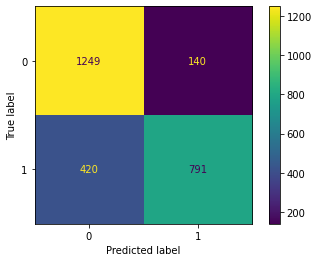

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(image_text_pred, label_test)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [50]:
from sklearn.linear_model import RidgeClassifier
reg = RidgeClassifier()
image_reg=reg.fit(image_pca,label_train)

In [51]:
image_pred=image_reg.predict(image_pca)

In [52]:
sum(abs(image_pred-label_train))

1860

In [53]:
image_text_pred=image_reg.predict(image_test_pca)

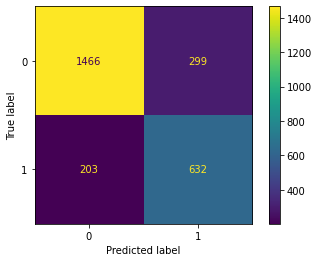

In [54]:
cm = confusion_matrix(image_text_pred, label_test)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [55]:
from sklearn import svm

In [56]:
clf = svm.SVC()

In [57]:
clf.fit(image_pca,label_train)

SVC()

In [58]:
image_pred=clf.predict(image_pca)

In [59]:
sum(abs(image_pred-label_train))

1313

In [60]:
image_text_pred=image_reg.predict(image_test_pca)

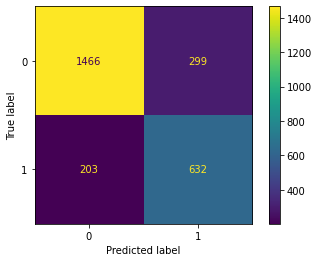

In [61]:
cm = confusion_matrix(image_text_pred, label_test)

cm_display = ConfusionMatrixDisplay(cm).plot()